In [21]:
 import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pickle
import timeit
import aesara.tensor as at
from arviz.plots import plot_utils as azpu
import pandas as pd
import decimal
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
import arviz as az
import matplotlib.gridspec as gridspec

from pymc import HalfCauchy, Model, Normal,sample, Uniform
print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v5.17.0


In [22]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")


In [23]:
with open('data_i1.pickle', 'rb') as f:
    
   beta_val,K_val,n_val,a1_val,beta1_val,K1_val,n1_val,K2_val,n2_val, a2_val, a3_val,k,x1_0,x2_0,x3_0,fT,t_ori,X1_ssa,X2_ssa,X3_ssa = pickle.load(f)

dt  =t_ori[1]-t_ori[0]
n_seq = len(t_ori)

beta_val,K_val,n_val,a1_val,beta1_val,K1_val,n1_val,K2_val,n2_val, a2_val, a3_val,k

(30, 70, 2, 0.03, 20, 10, 2, 300, 2, 0.03, 0.09, 3)

In [24]:
def return_data(n_data,type_data,t_last):
    # This function is only for bring the data.
    x1_ssa = X1_ssa
    x2_ssa = X2_ssa
    x3_ssa =  X3_ssa
    if type_data == 'ssa':
        x1 = x1_ssa.copy()
        x2 = x2_ssa.copy()
        x3 = x3_ssa.copy()
    XX1 = x1[:-1]
    dXX1 = x1[1:]- x1[:-1]
    XX2 = x2[:-1]
    dXX2 = x2[1:]- x2[:-1]
    XX3 = x3[:-1]
    dXX3 = x3[1:]- x3[:-1]
    
    return XX1[:t_last], dXX1[:t_last], XX2[:t_last], dXX2[:t_last],XX3[:t_last], dXX3[:t_last]

1000
5


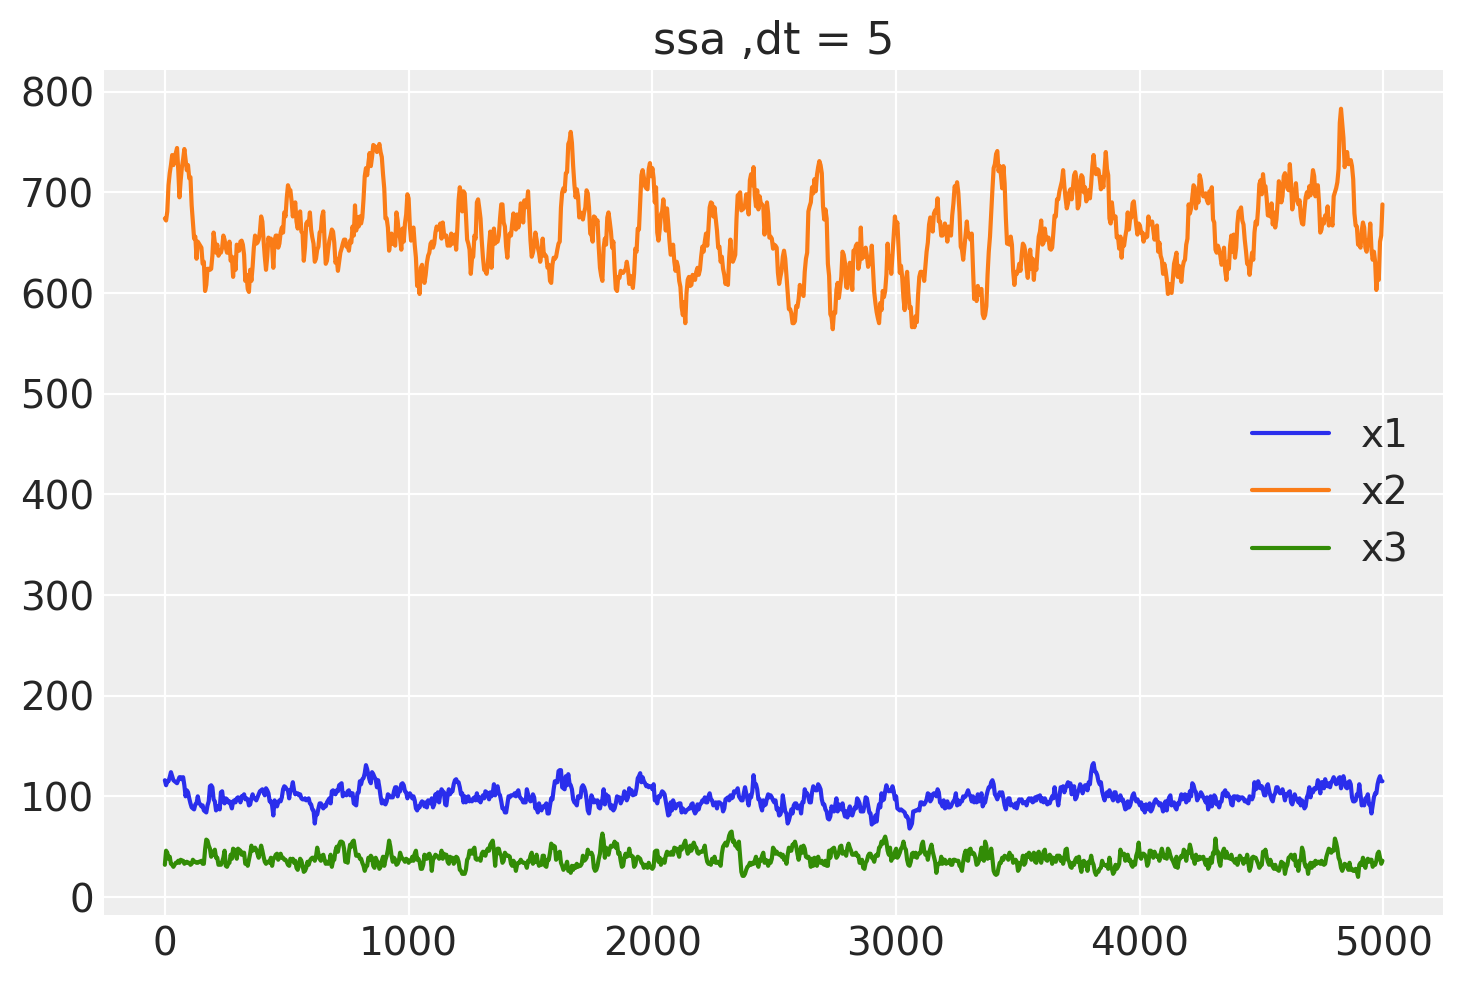

In [25]:
Type_data = ['ssa']
n_type = 0

# decide length of trajectory 
t_last = 1000

# decide dt
DT= [5]
n_dt = 0 

# which trajectories will be used. 
n_data = 0

type_data = Type_data[n_type]
dt = DT[n_dt]
print(len(t_ori[:t_last]))
#print(len(XX1))
#print(dXX1)
#print(dXX2)
#print(dXX3)
print(dt)
XX1, dXX1, XX2, dXX2,XX3,dXX3 = return_data(n_data,type_data,t_last)

plt.plot(t_ori[:t_last],XX1,label = 'x1')
plt.plot(t_ori[:t_last], XX2, label = 'x2')
plt.plot(t_ori[:t_last], XX3, label = 'x3')
plt.title(type_data+' ,dt = %s' %dt)
plt.legend()

In [26]:
def compute_F1(dt, delta1, beta1, beta2, beta3, beta4, beta5, beta6, beta7, beta8,
               x2t, x3t, K, K1, n, n1, r1, a1, x1t):
    F1 = dt * (
        delta1 * (
            beta1 * (x2t**n) / (x2t**n + K**n) +
            beta2 * (K**n) / (x2t**n + K**n) +
            beta3 * (x3t**n1) / (x3t**n1 + K1**n1) +
            beta4 * (K1**n1) / (x3t**n1 + K1**n1)
        ) +
        (1 - delta1) * (
            beta5 * (x2t**n * x3t**n1) / ((x2t**n + K**n) * (x3t**n1 + K1**n1)) +
            beta6 * (K**n * x3t**n1) / ((x2t**n + K**n) * (x3t**n1 + K1**n1)) +
            beta7 * (x2t**n * K1**n1) / ((x2t**n + K**n) * (x3t**n1 + K1**n1)) +
            beta8 * (K**n * K1**n1) / ((x2t**n + K**n) * (x3t**n1 + K1**n1))
        )
    ) + r1 - a1 * x1t
    
    return F1

def compute_G1(dt, delta1, beta1, beta2, beta3, beta4, beta5, beta6, beta7, beta8,
               x2t, x3t, K, K1, n, n1, r1, a1, x1t):
    G1 = np.sqrt(dt) * np.sqrt(
        delta1 * (
            abs(beta1 * (x2t**n) / (x2t**n + K**n)) +
            abs(beta2 * (K**n) / (x2t**n + K**n)) +
            abs(beta3 * (x3t**n1) / (x3t**n1 + K1**n1)) +
            abs(beta4 * (K1**n1) / (x3t**n1 + K1**n1))
        ) +
       (1 - delta1) * (
            abs(beta5 * (x2t**n * x3t**n1) / ((x2t**n + K**n) * (x3t**n1 + K1**n1))) +
            abs(beta6 * (K**n * x3t**n1) / ((x2t**n + K**n) * (x3t**n1 + K1**n1))) +
            abs(beta7 * (x2t**n * K1**n1) / ((x2t**n + K**n) * (x3t**n1 + K1**n1))) +
            abs(beta8 * (K**n * K1**n1) / ((x2t**n + K**n) * (x3t**n1 + K1**n1)))
        ) +
        abs(r1) +
        abs(a1 * x1t)
    )
        
    return G1

def compute_likelihood1(dx1t, F1, G1):
    likelihood = (1 / (np.sqrt(2 * np.pi) * G1)) * np.exp(-0.5 * ((dx1t - F1) / G1)**2)
    likelihood1=np.prod(likelihood)
    return likelihood1

def compute_log_likelihood1(dx1t, F1, G1):
    log_likelihood1 = np.sum(np.log((1 / (np.sqrt(2 * np.pi) * G1)) * np.exp(-0.5 * ((dx1t - F1) / G1)**2)))
    return log_likelihood1


In [27]:
def compute_F2(dt, delta2, beta9, beta10, beta11, beta12, beta13, beta14, beta15, beta16,
               x1t, x3t, K, K2, n, n2, r2, a2, x2t):
    F2 = dt * (
        delta2 * (
            beta9 * (x1t**n) / (x1t**n + K**n) +
            beta10 * (K**n) / (x1t**n + K**n) +
            beta11 * (x3t**n2) / (x3t**n2 + K2**n2) +
            beta12 * (K2**n2) / (x3t**n2 + K2**n2)
        ) +
        (1 - delta2) * (
            beta13 * (x1t**n * x3t**n2) / ((x1t**n + K**n) * (x3t**n2 + K2**n2)) +
            beta14 * (K**n * x3t**n2) / ((x1t**n + K**n) * (x3t**n2 + K2**n2)) +
            beta15 * (x1t**n * K2**n2) / ((x1t**n + K**n) * (x3t**n2 + K2**n2)) +
            beta16 * (K**n * K2**n2) / ((x1t**n + K**n) * (x3t**n2 + K2**n2))
        ) -
        a2 * x2t + r2
    )
    return F2

def compute_G2(dt, delta2, beta9, beta10, beta11, beta12, beta13, beta14, beta15, beta16,
               x1t, x3t, K, K2, n, n2, r2, a2, x2t):
    G2 = np.sqrt(dt) * (
        np.sqrt(
            delta2 * (
                abs(beta9 * (x1t**n) / (x1t**n + K**n)) +
                abs(beta10 * (K**n) / (x1t**n + K**n)) +
                abs(beta11 * (x3t**n2) / (x3t**n2 + K2**n2)) +
                abs(beta12 * (K2**n2) / (x3t**n2 + K2**n2))
            ) +
            (1 - delta2) * (
                abs(beta13 * (x1t**n * x3t**n2) / ((x1t**n + K**n) * (x3t**n2 + K2**n2))) +
                abs(beta14 * (K**n * x3t**n2) / ((x1t**n + K**n) * (x3t**n2 + K2**n2))) +
                abs(beta15 * (x1t**n * K2**n2) / ((x1t**n + K**n) * (x3t**n2 + K2**n2))) +
                abs(beta16 * (K**n * K2**n2) / ((x1t**n + K**n) * (x3t**n2 + K2**n2)))
            ) +
            abs(a2 * x2t) + abs(r2)
        )
    )
    return G2

def compute_likelihood2(dx2t, F2, G2):
    likelihood = (1 / (np.sqrt(2 * np.pi) * G2)) * np.exp(-0.5 * ((dx2t - F2) / G2)**2)
    likelihood2=np.prod(likelihood)
    return likelihood2

def compute_log_likelihood2(dx2t, F2, G2):
    log_likelihood2 = np.sum(np.log((1 / (np.sqrt(2 * np.pi) * G2)) * np.exp(-0.5 * ((dx2t - F2) / G2)**2)))
    return log_likelihood2

In [28]:
def compute_F3(dt, delta3, beta17, beta18, beta19, beta20, beta21, beta22, beta23, beta24,
               x1t, x2t, K1, K2, n1, n2, r3, a3, x3t):
    F3 = dt * (
        delta3 * (
            beta17 * (x1t**n1) / (x1t**n1 + K1**n1) +
            beta18 * (K1**n1) / (x1t**n1 + K1**n1) +
            beta19 * (x2t**n2) / (x2t**n2 + K2**n2) +
            beta20 * (K2**n2) / (x2t**n2 + K2**n2)
        ) +
        (1 - delta3) * (
            beta21 * (x1t**n1 * x2t**n2) / ((x1t**n1 + K1**n1) * (x2t**n2 + K2**n2)) +
            beta22 * (K1**n1 * x2t**n2) / ((x1t**n1 + K1**n1) * (x2t**n2 + K2**n2)) +
            beta23 * (x1t**n1 * K2**n2) / ((x1t**n1 + K1**n1) * (x2t**n2 + K2**n2)) +
            beta24 * (K1**n1 * K2**n2) / ((x1t**n1 + K1**n1) * (x2t**n2 + K2**n2))
        ) -
        a3 * x3t + r3
    )
    return F3

def compute_G3(dt, delta3, beta17, beta18, beta19, beta20, beta21, beta22, beta23, beta24,
               x1t, x2t, K1, K2, n1, n2, r3, a3, x3t):
    G3 = np.sqrt(dt) * (
        np.sqrt(
            delta3 * (
                abs(beta17 * (x1t**n1) / (x1t**n1 + K1**n1)) +
                abs(beta18 * (K1**n1) / (x1t**n1 + K1**n1)) +
                abs(beta19 * (x2t**n2) / (x2t**n2 + K2**n2)) +
                abs(beta20 * (K2**n2) / (x2t**n2 + K2**n2))
            ) +
            (1 - delta3) * (
                abs(beta21 * (x1t**n1 * x2t**n2) / ((x1t**n1 + K1**n1) * (x2t**n2 + K2**n2))) +
                abs(beta22 * (K1**n1 * x2t**n2) / ((x1t**n1 + K1**n1) * (x2t**n2 + K2**n2))) +
                abs(beta23 * (x1t**n1 * K2**n2) / ((x1t**n1 + K1**n1) * (x2t**n2 + K2**n2))) +
                abs(beta24 * (K1**n1 * K2**n2) / ((x1t**n1 + K1**n1) * (x2t**n2 + K2**n2)))
            ) +
            abs(a3 * x3t) + abs(r3)
        )
    )
    return G3

def compute_likelihood3(dx3t, F3, G3):
    likelihood = (1 / (np.sqrt(2 * np.pi) * G3)) * np.exp(-0.5 * ((dx3t - F3) / G3)**2)
    likelihood3=np.prod(likelihood)
    return likelihood3

def compute_log_likelihood3(dx3t, F3, G3):
    log_likelihood3 = np.sum(np.log((1 / (np.sqrt(2 * np.pi) * G3)) * np.exp(-0.5 * ((dx3t - F3) / G3)**2)))
    return log_likelihood3

/var/folders/w3/hzwt60zj039d93rcpm0qt4l40000gn/T/ipykernel_6068/3911661699.py:49: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


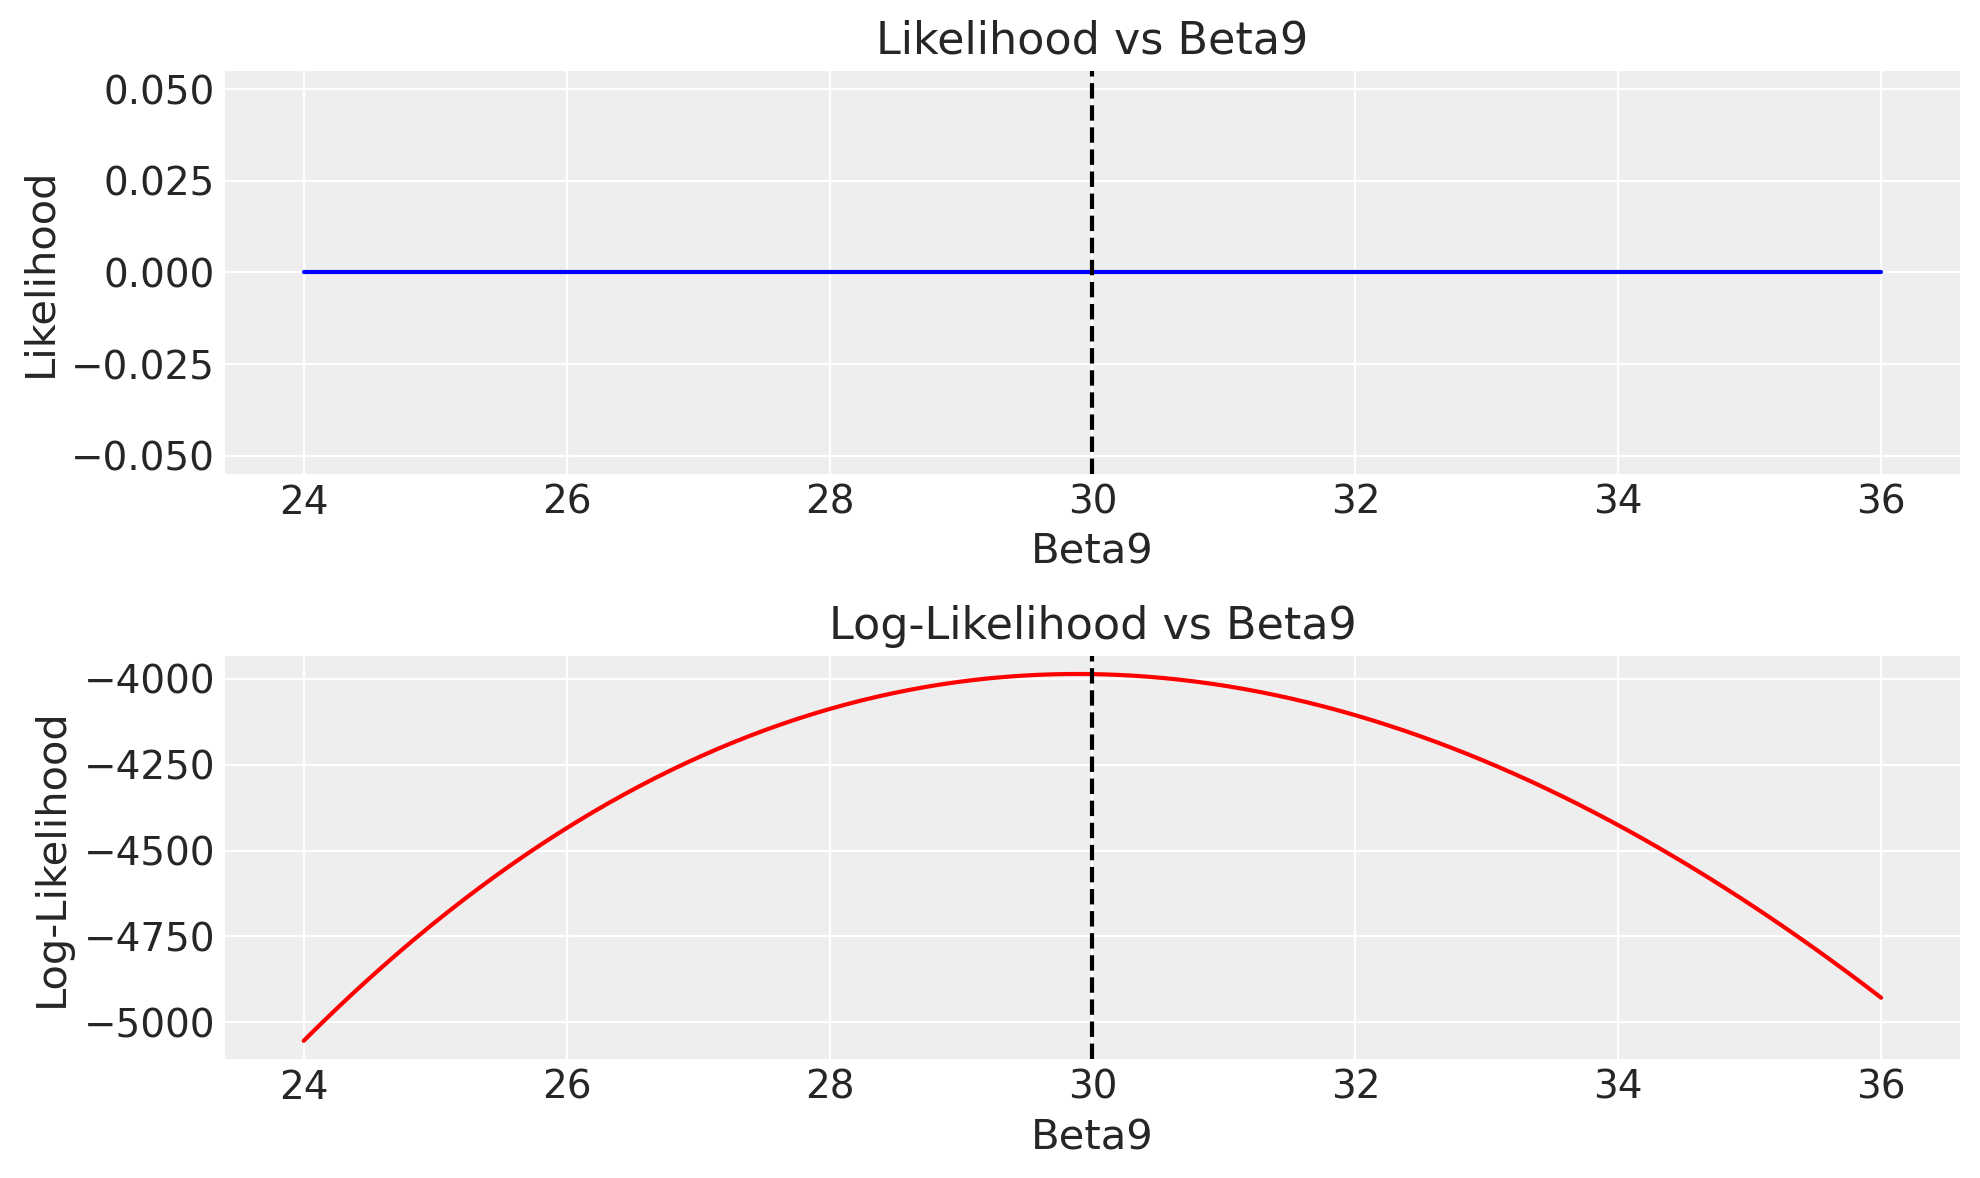

In [29]:

dt, delta2, beta10, beta11, beta12, beta13, beta14, beta15, beta16 = 5, 1, 0, 0, 0, 0, 0, 0, 0
x1t, x3t, K, K2, n, n2, r2, a2, x2t = XX1, XX3, K_val, K2_val, n_val, n2_val, 0, a2_val, XX2
dx2t = dXX2

# Define the range for beta9
beta9 = np.linspace(beta_val * 0.8, beta_val * 1.2, 100)
#beta9 = np.linspace(0,500, 100)


L_b9 = []
Log_L_b9 = []

# Loop over each beta9 value and compute F2, G2, likelihood, and log-likelihood
for b9 in beta9:
    # Recompute F2, G2 for the current beta9
    F2_val = compute_F2(dt, delta2, b9, beta10, beta11, beta12, beta13, beta14, beta15, beta16,
                        x1t, x3t, K, K2, n, n2, r2, a2, x2t)
    G2_val = compute_G2(dt, delta2, b9, beta10, beta11, beta12, beta13, beta14, beta15, beta16,
                        x1t, x3t, K, K2, n, n2, r2, a2, x2t)

    # Compute likelihood and log-likelihood for the current values of F2 and G2
    L_b9.append(compute_likelihood2(dx2t, F2_val, G2_val))
    Log_L_b9.append(compute_log_likelihood2(dx2t, F2_val, G2_val))


L_b9 = np.array(L_b9)
Log_L_b9 = np.array(Log_L_b9)

# Plot the likelihood and log-likelihood for each beta9
plt.figure(figsize=(10, 6))


plt.subplot(2, 1, 1)
plt.plot(beta9, L_b9, label='Likelihood', color='blue')
plt.axvline(x=beta_val, ls='--', linewidth=1.5, c='black')
plt.xlabel('Beta9')
plt.ylabel('Likelihood')
plt.title('Likelihood vs Beta9')
plt.grid(True)


plt.subplot(2, 1, 2)
plt.plot(beta9, Log_L_b9, label='Log-Likelihood', color='red')
plt.axvline(x=beta_val, ls='--', linewidth=1.5, c='black')
plt.xlabel('Beta9')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood vs Beta9')
plt.grid(True)
plt.tight_layout()
plt.show()

# last computed values of F2, G2, Likelihood, and Log-Likelihood
#print("F2:", F2_val)
#print("G2:", G2_val)
#print("Likelihood for beta9:", L_b9[-1])
#print("Log-Likelihood for  beta9:", Log_L_b9[-1])

/var/folders/w3/hzwt60zj039d93rcpm0qt4l40000gn/T/ipykernel_6068/832373418.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


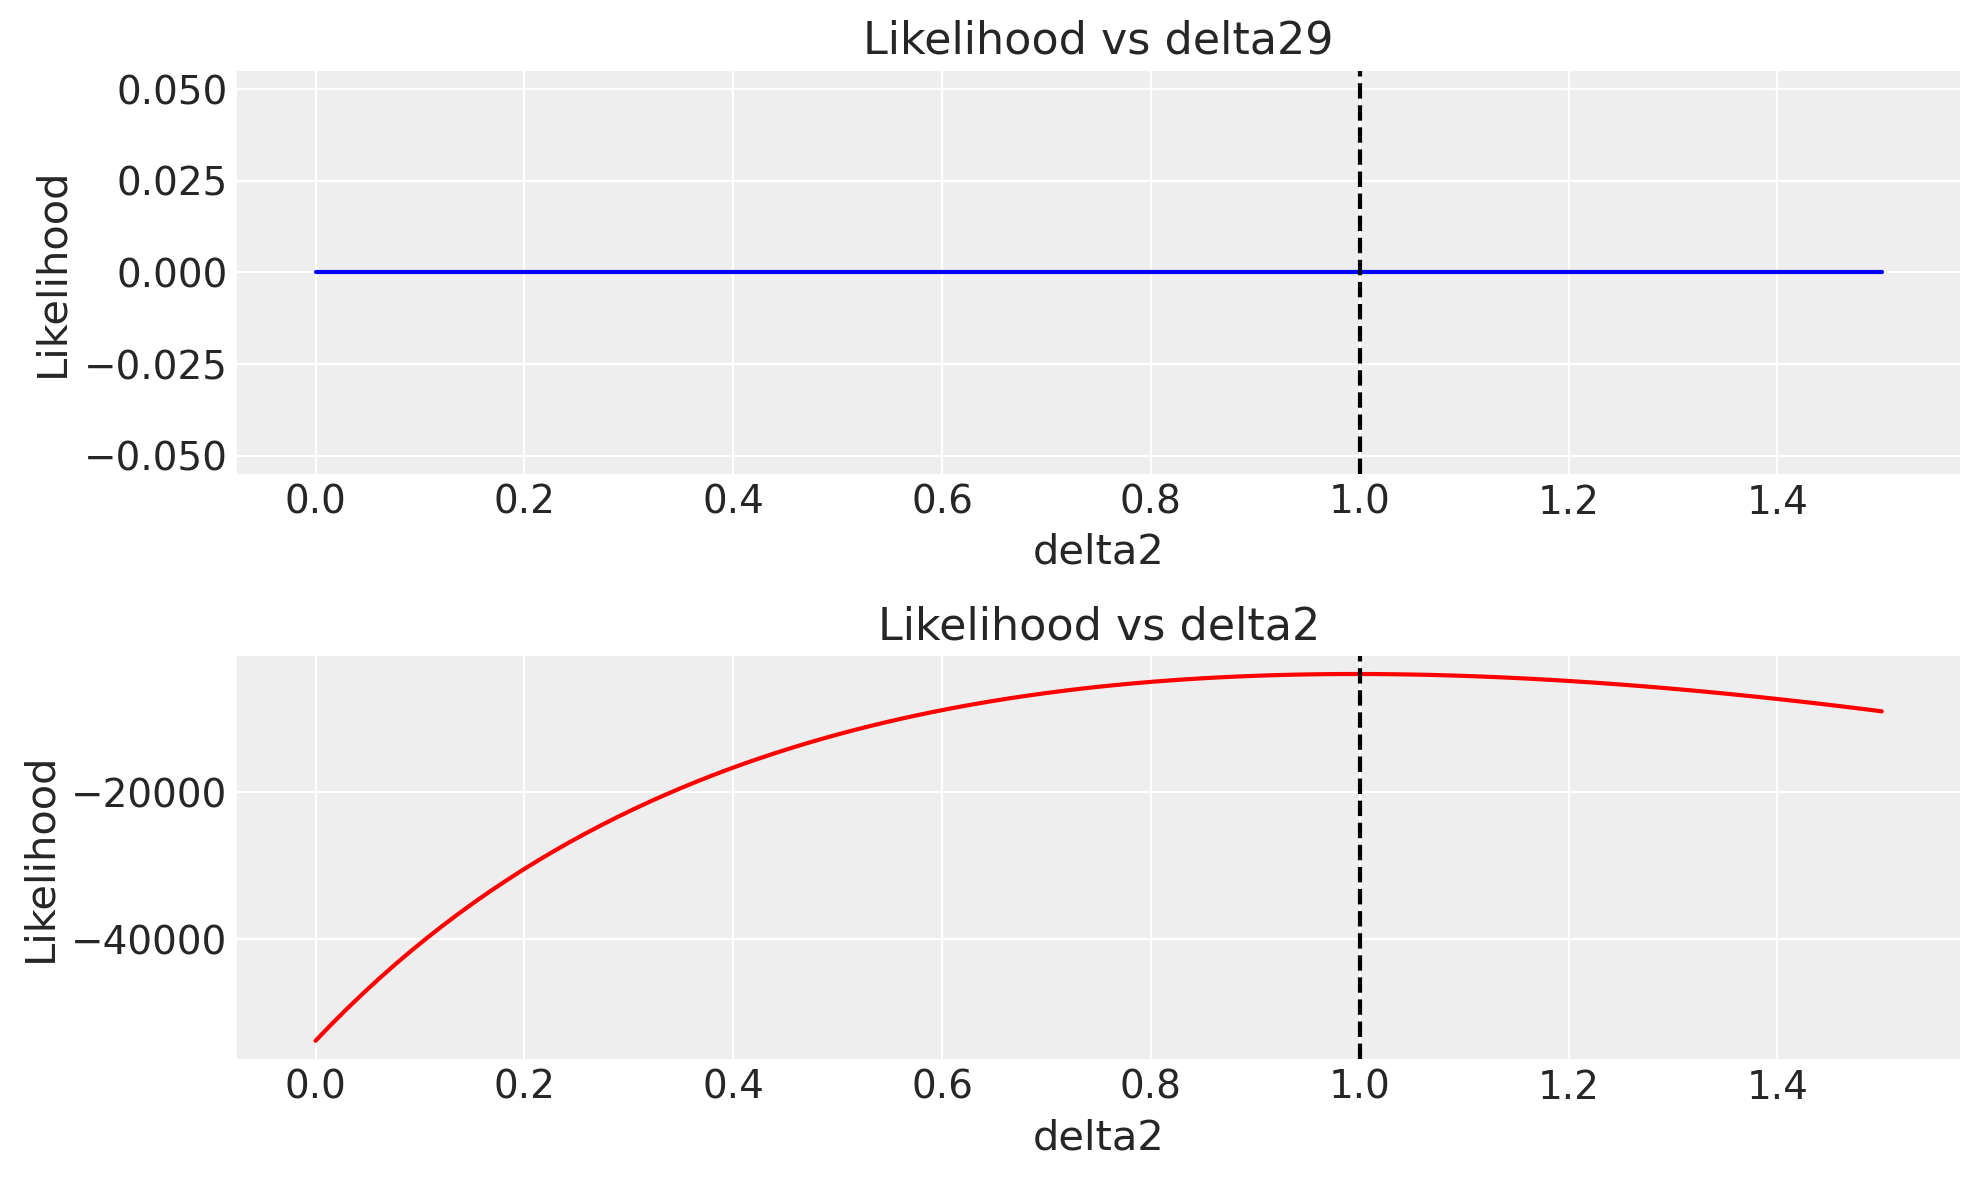

In [34]:
dt,beta9, beta10, beta11, beta12, beta13, beta14, beta15, beta16 = 5,beta_val, 0, 0, 0, 0, 0, 0, 0
x1t, x3t, K, K2, n, n2, r2, a2, x2t = XX1, XX3, K_val, K2_val, n_val, n2_val, 0, a2_val, XX2
dx2t = dXX2


delta_true=1
#delta2 = np.linspace(delta_true * 0.8, 5, 100)
delta2 = np.linspace(0,1.5, 100)


L_d2 = []
Log_L_d2 = []


for d2 in delta2:
    # Recompute F2, G2 for the current beta9
    F2_val = compute_F2(dt, d2, beta9, beta10, beta11, beta12, beta13, beta14, beta15, beta16,
                        x1t, x3t, K, K2, n, n2, r2, a2, x2t)
    G2_val = compute_G2(dt, d2, beta9, beta10, beta11, beta12, beta13, beta14, beta15, beta16,
                        x1t, x3t, K, K2, n, n2, r2, a2, x2t)

    # Compute likelihood and log-likelihood for the current values of F2 and G2
    L_d2.append(compute_likelihood2(dx2t, F2_val, G2_val))
    Log_L_d2.append(compute_log_likelihood2(dx2t, F2_val, G2_val))


L_d2 = np.array(L_d2)
Log_L_d2 = np.array(Log_L_d2)

# Plot the likelihood and log-likelihood for each beta9
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(delta2, L_d2, label='Likelihood', color='blue')
plt.axvline(x=delta_true, ls='--', linewidth=1.5, c='black')
plt.xlabel('delta2')
plt.ylabel('Likelihood')
plt.title('Likelihood vs delta29')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(delta2, Log_L_d2, label='Log-Likelihood', color='red')
plt.axvline(x=delta_true, ls='--', linewidth=1.5, c='black')
plt.xlabel('delta2')
plt.ylabel('Likelihood')
plt.title('Likelihood vs delta2')
plt.grid(True)
plt.tight_layout()
plt.show()

# print the last computed values of F2, G2, Likelihood, and Log-Likelihood
#print("F2:", F2_val)
#print("G2:", G2_val)
#print("Likelihood for last beta9:", L_b9[-1])
#print("Log-Likelihood for last beta9:", Log_L_b9[-1])

/var/folders/w3/hzwt60zj039d93rcpm0qt4l40000gn/T/ipykernel_6068/726133734.py:40: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


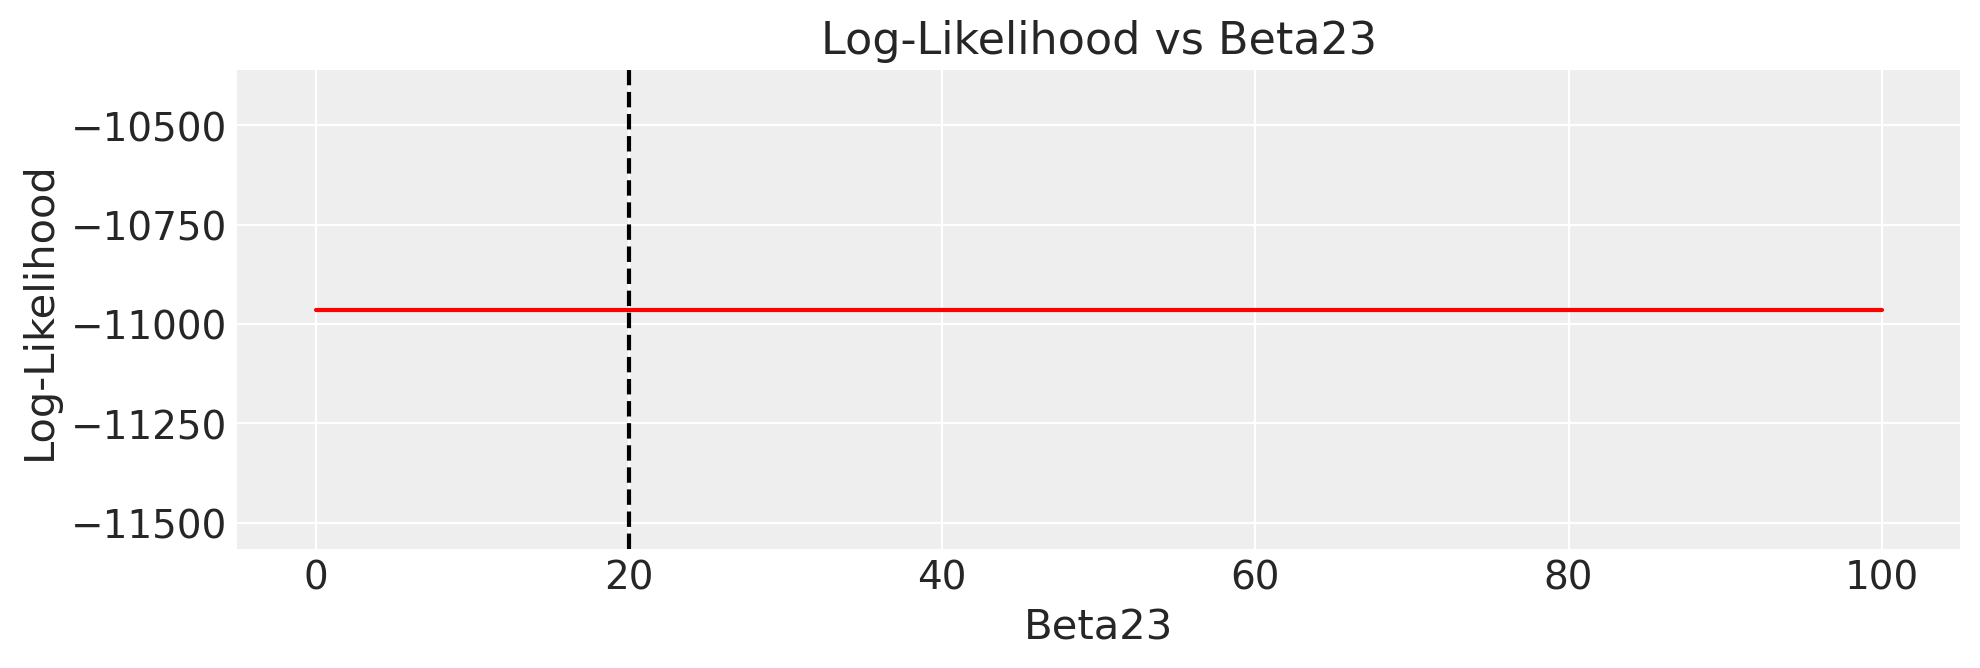

In [31]:
dt, delta3, beta17, beta18, beta19, beta20, beta21, beta22, beta24 = 5, 0, 0, 0, 0, 0, 0, 0, 0
x1t, x2t, K1, K2, n1, n2, r3, a3, x3t = XX1, XX2, K1_val, K2_val, n1_val, n2_val, 0, a3_val, XX3
dx3t = dXX3

# Define the range 
#beta23 = np.linspace(beta1_val * 0.8, beta1_val * 1.2, 1000
beta23 = np.linspace(0,100, 1000)                  
L_b23 = []
Log_L_b23 = []

# Loop over each beta23 value and compute F3, G3, likelihood, and log-likelihood
for b23 in beta23:
    # Recompute F3, G3 for the current beta9
    F3_val = compute_F3(dt, delta3, beta17, beta18, beta19, beta20, beta21, beta22, beta23, beta24,
               x1t, x2t, K1, K2, n1, n2, r3, a3, x3t)
    G3_val = compute_G3(dt, delta3, beta17, beta18, beta19, beta20, beta21, beta22, beta23, beta24,
               x1t, x2t, K1, K2, n1, n2, r3, a3, x3t)

    # Compute likelihood and log-likelihood for the current values of F2 and G2
    L_b23.append(compute_likelihood3(dx3t, F3_val, G3_val))
    Log_L_b23.append(compute_log_likelihood3(dx3t, F3_val, G3_val))


L_b23 = np.array(L_b23)
Log_L_b23 = np.array(Log_L_b23)

# Plot the likelihood and log-likelihood for each beta23
plt.figure(figsize=(10, 6))




plt.subplot(2, 1, 2)
plt.plot(beta23, Log_L_b23, label='Log-Likelihood', color='red')
plt.axvline(x=beta1_val, ls='--', linewidth=1.5, c='black')
plt.xlabel('Beta23')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood vs Beta23')
plt.grid(True)
plt.tight_layout()
plt.show()



/var/folders/w3/hzwt60zj039d93rcpm0qt4l40000gn/T/ipykernel_6068/263024138.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


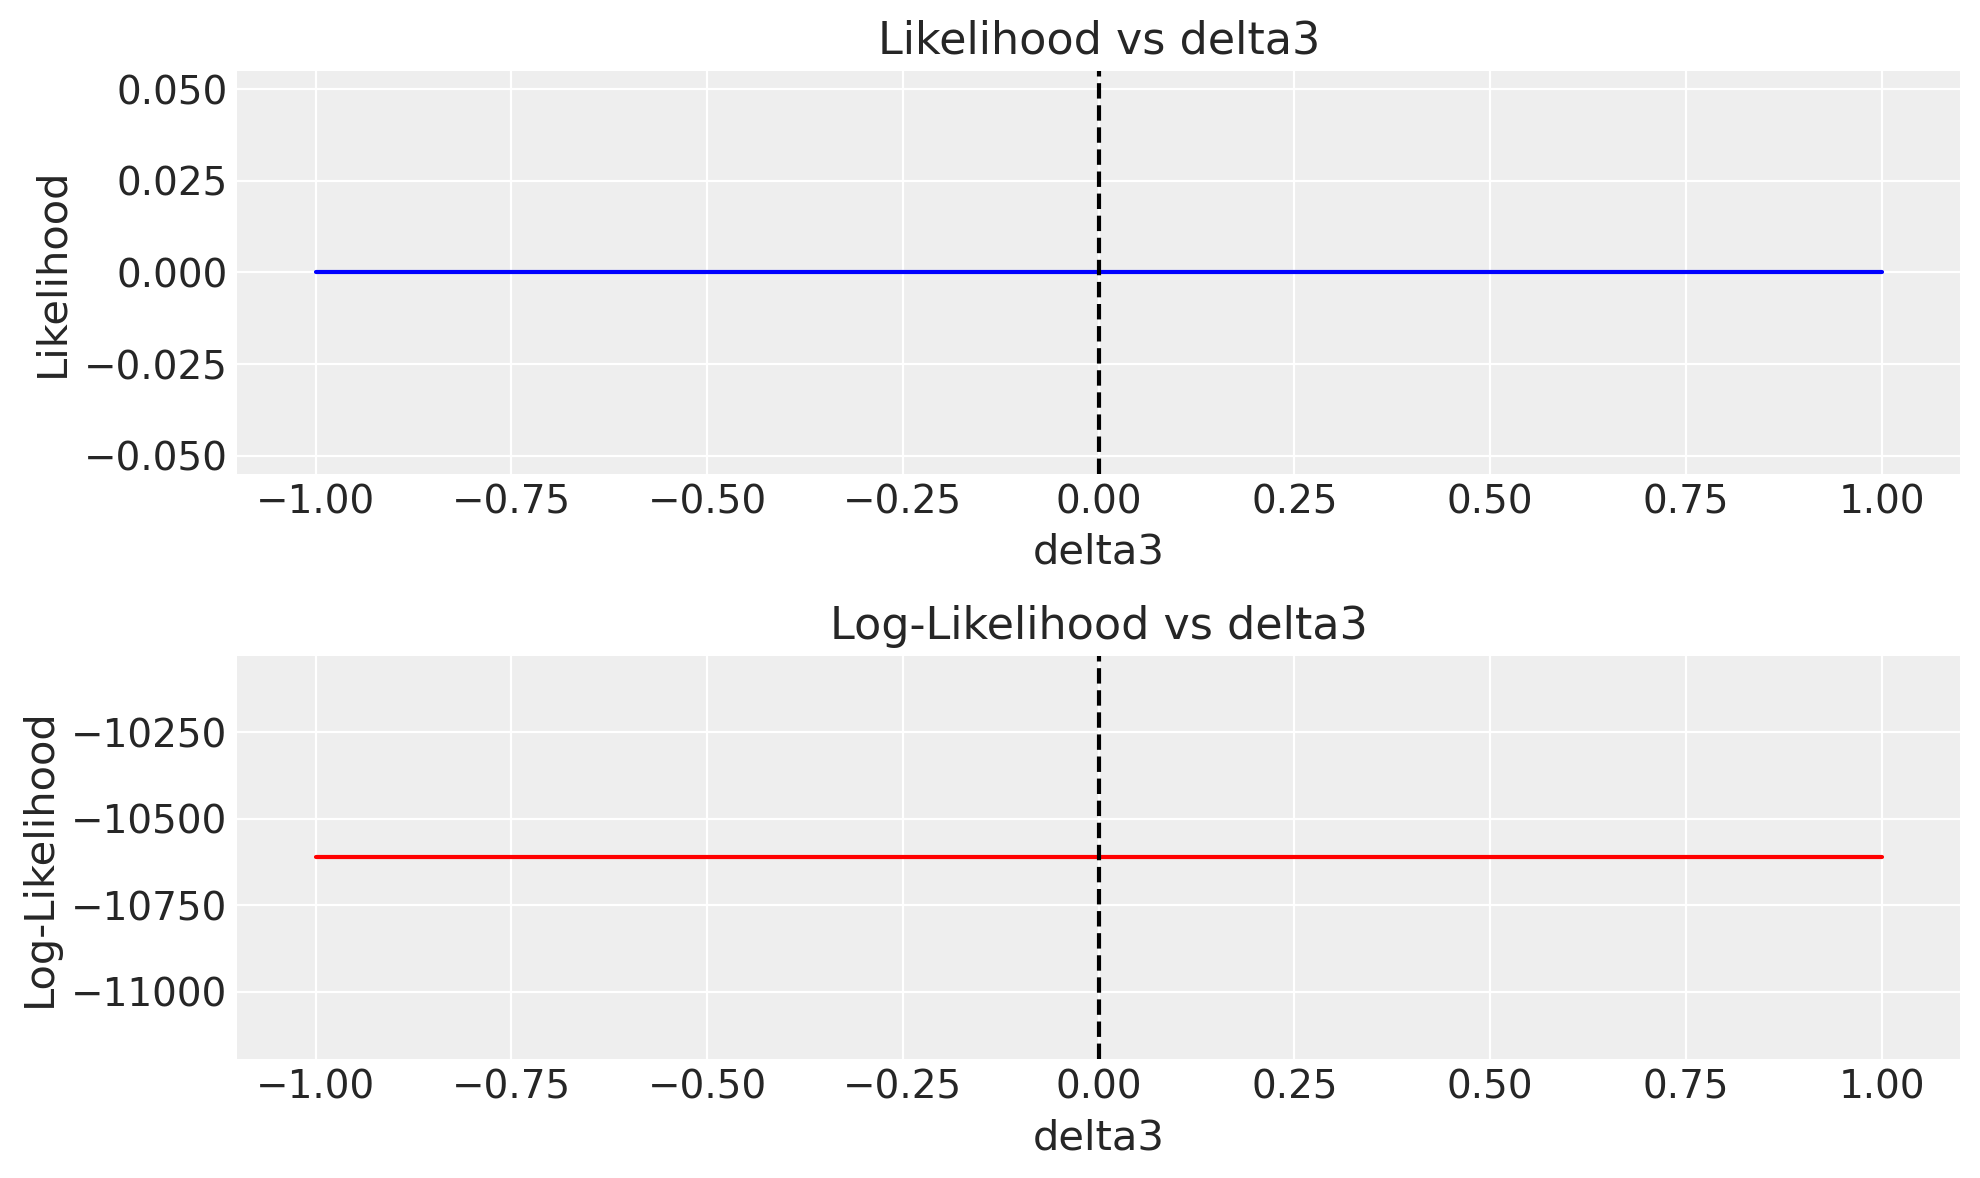

In [35]:
dt, delta3, beta17, beta18, beta19, beta20, beta21, beta22,beta23, beta24 = 5, 0, 0, 0, 0, 0, 0, beta1_val,0, 0
x1t, x2t, K1, K2, n1, n2, r3, a3, x3t = XX1, XX2, K1_val, K2_val, n1_val, n2_val, 0, a3_val, XX3
dx3t = dXX3

# Define the range 

delta3 = np.linspace(-1,1, 1000)                  
L_d3 = []
Log_L_d3 = []


for d3 in delta3:
   
    F3_val = compute_F3(dt, delta3, beta17, beta18, beta19, beta20, beta21, beta22, beta23, beta24,
               x1t, x2t, K1, K2, n1, n2, r3, a3, x3t)
    G3_val = compute_G3(dt, delta3, beta17, beta18, beta19, beta20, beta21, beta22, beta23, beta24,
               x1t, x2t, K1, K2, n1, n2, r3, a3, x3t)

    # Compute likelihood and log-likelihood for the current values of F2 and G2
    L_d3.append(compute_likelihood3(dx3t, F3_val, G3_val))
    Log_L_d3.append(compute_log_likelihood3(dx3t, F3_val, G3_val))


L_d3 = np.array(L_d3)
Log_L_d3 = np.array(Log_L_d3)

# Plot the likelihood and log-likelihood for each beta23
plt.figure(figsize=(10, 6))


plt.subplot(2, 1, 1)
plt.plot(delta3, L_d3, label='Likelihood', color='blue')
plt.axvline(x=0, ls='--', linewidth=1.5, c='black')
plt.xlabel('delta3')
plt.ylabel('Likelihood')
plt.title('Likelihood vs delta3')
plt.grid(True)


plt.subplot(2, 1, 2)
plt.plot(delta3, Log_L_d3, label='Log-Likelihood', color='red')
plt.axvline(x=0, ls='--', linewidth=1.5, c='black')
plt.xlabel('delta3')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood vs delta3')
plt.grid(True)
plt.tight_layout()
plt.show()



/var/folders/w3/hzwt60zj039d93rcpm0qt4l40000gn/T/ipykernel_6068/727427981.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


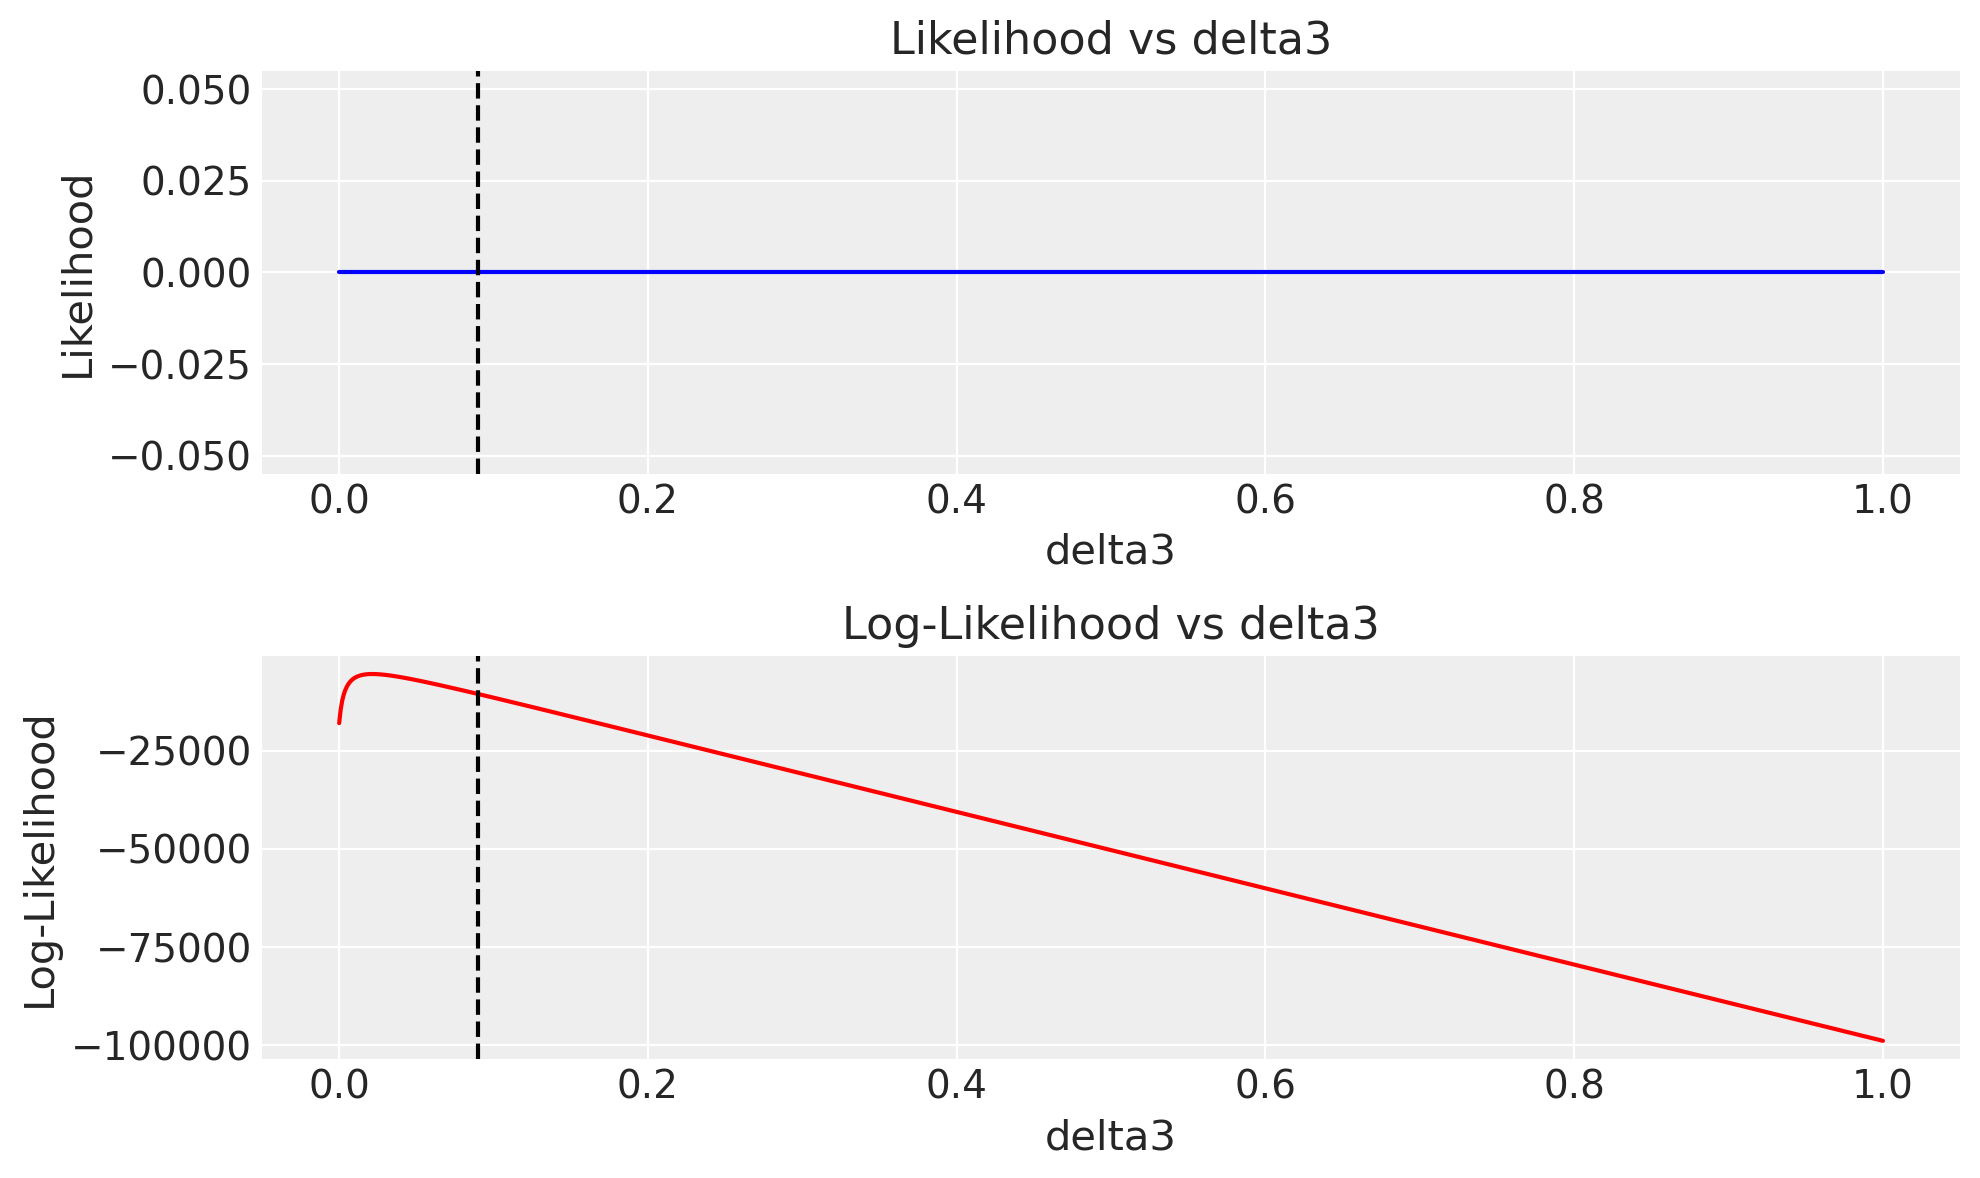

In [38]:
dt, delta3, beta17, beta18, beta19, beta20, beta21, beta22,beta23, beta24 = 5, 0, 0, 0, 0, 0, 0, beta1_val,0, 0
x1t, x2t, K1, K2, n1, n2, r3, x3t = XX1, XX2, K1_val, K2_val, n1_val, n2_val, 0,  XX3
dx3t = dXX3

# Define the range 

A3 = np.linspace(0,1, 1000)                  
L_a3 = []
Log_L_a3 = []


for a3 in A3:
   
    F3_val = compute_F3(dt, delta3, beta17, beta18, beta19, beta20, beta21, beta22, beta23, beta24,
               x1t, x2t, K1, K2, n1, n2, r3, a3, x3t)
    G3_val = compute_G3(dt, delta3, beta17, beta18, beta19, beta20, beta21, beta22, beta23, beta24,
               x1t, x2t, K1, K2, n1, n2, r3, a3, x3t)

    # Compute likelihood and log-likelihood for the current values of F2 and G2
    L_a3.append(compute_likelihood3(dx3t, F3_val, G3_val))
    Log_L_a3.append(compute_log_likelihood3(dx3t, F3_val, G3_val))


L_a3 = np.array(L_a3)
Log_L_a3 = np.array(Log_L_a3)

# Plot the likelihood and log-likelihood for each beta23
plt.figure(figsize=(10, 6))


plt.subplot(2, 1, 1)
plt.plot(A3, L_a3, label='Likelihood', color='blue')
plt.axvline(x=a3_val, ls='--', linewidth=1.5, c='black')
plt.xlabel('delta3')
plt.ylabel('Likelihood')
plt.title('Likelihood vs delta3')
plt.grid(True)


plt.subplot(2, 1, 2)
plt.plot(A3, Log_L_a3, label='Log-Likelihood', color='red')
plt.axvline(x=a3_val, ls='--', linewidth=1.5, c='black')
plt.xlabel('delta3')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood vs delta3')
plt.grid(True)
plt.tight_layout()
plt.show()

